## 1. Environment Setup

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

## 2. Create and Populate SQLite Tables

In [44]:
conn = sqlite3.connect("Ecommerce data.db")
cursor = conn.cursor()


cursor.executescript("""
DROP TABLE IF EXISTS Customers;
DROP TABLE IF EXISTS Products;
DROP TABLE IF EXISTS Orders;

CREATE TABLE Customers (
    CustomerID INTEGER PRIMARY KEY,
    Name TEXT,
    Gender TEXT,
    Country TEXT
);

CREATE TABLE Products (
    ProductID INTEGER PRIMARY KEY,
    ProductName TEXT,
    Category TEXT,
    Price REAL
);

CREATE TABLE Orders (
    OrderID INTEGER PRIMARY KEY,
    CustomerID INTEGER,
    ProductID INTEGER,
    Quantity INTEGER,
    OrderDate TEXT,
    FOREIGN KEY (CustomerID) REFERENCES Customers(CustomerID),
    FOREIGN KEY (ProductID) REFERENCES Products(ProductID)
);
""")

# Insert sample data
customers = [
    (101, 'Alice', 'Female', 'Canada'),
    (102, 'Bob', 'Male', 'UK'),
    (103, 'Clara', 'Female', 'Canada'),
    (104, 'David', 'Male', 'UK'),
    (105,  'Bob', 'Male', 'UK'),
   (106, 'Alice', 'Female', 'USA'),
    (107, 'Rani', 'Female', 'USA'),
    (108, 'sunitha', 'Female', 'UK'),
    (109, 'Mahesh', 'male', 'USA'),
    (110, 'Anitha', 'Female', 'Canada'),
]

cursor.executemany(
    "INSERT INTO Customers (CustomerID, Name, Gender, Country) VALUES (?, ?, ?, ?)",
    customers
)

products = [
    (1, 'Laptop', 'Electronics', 1000),
    (2, 'Mouse', 'Accessories', 250),
    (3, 'Chair', 'Furniture', 150),
    (4, 'Desk', 'Furniture', 300),
    (5, 'Desk', 'Furniture', 300),
    (6, 'Laptop', 'Electronics', 1000),
    (7, 'Laptop', 'Electronics', 1000),
    (8, 'Mouse', 'Accessories', 250),
    (9, 'Laptop', 'Electronics', 1000),
    (10, 'Chair', 'Furniture', 300),
]
cursor.executemany(
    "INSERT INTO products (ProductID,  ProductName, Category, Price) VALUES (?, ?, ?, ?)",
    products
)
orders = [
    (1, 102, 1, 1, '2025-03-01'),
    (2, 103, 2, 2, '2025-04-03'),
    (3, 101, 3, 1, '2025-03-05'),
    (4, 101, 2, 3, '2025-04-07'),
    (5, 104, 4, 1, '2025-04-10'),
    (6, 106, 1, 1, '2025-08-12'),
     (7, 105, 5, 3, '2025-06-8'),
     (8, 109, 1, 2, '2025-06-6'),
     (9, 107, 6, 4, '2025-07-5'),
     (10, 108, 8, 2, '2025-07-3'),
]
cursor.executemany(
    "INSERT INTO orders (OrderID, CustomerID, ProductID, Quantity, OrderDate) VALUES (?, ?, ?, ?, ?)",
    orders
)
conn.commit()


## 3. SQL Query - Total Orders by Country

In [45]:
query_country_orders = """
SELECT 
    c.Country,
    COUNT(o.OrderID) AS TotalOrders
FROM Customers c
LEFT JOIN Orders o ON c.CustomerID = o.CustomerID
GROUP BY c.Country
ORDER BY TotalOrders DESC;
"""

df_country_orders = pd.read_sql(query_country_orders, conn)
df_country_orders

,Country,TotalOrders
0,UK,4
1,USA,3
2,Canada,3


## 4. Load Full Dataset for EDA

In [46]:
query_full = """
SELECT 
    o.OrderID,
    c.Name AS Customer,
    c.Gender,
    c.Country,
    p.ProductName,
    p.Category,
    p.Price,
    o.Quantity,
    o.OrderDate,
    (p.Price * o.Quantity) AS TotalAmount
FROM Orders o
JOIN Customers c ON o.CustomerID = c.CustomerID
JOIN Products p ON o.ProductID = p.ProductID;
"""
df_orders = pd.read_sql(query_full, conn)
df_orders.head(10)


,OrderID,Customer,Gender,Country,ProductName,Category,Price,Quantity,OrderDate,TotalAmount
0,1,Bob,Male,UK,Laptop,Electronics,1000.0,1,2025-03-01,1000.0
1,2,Clara,Female,Canada,Mouse,Accessories,250.0,2,2025-04-03,500.0
2,3,Alice,Female,Canada,Chair,Furniture,150.0,1,2025-03-05,150.0
3,4,Alice,Female,Canada,Mouse,Accessories,250.0,3,2025-04-07,750.0
4,5,David,Male,UK,Desk,Furniture,300.0,1,2025-04-10,300.0
5,6,Alice,Female,USA,Laptop,Electronics,1000.0,1,2025-08-12,1000.0
6,7,Bob,Male,UK,Desk,Furniture,300.0,3,2025-06-8,900.0
7,8,Mahesh,male,USA,Laptop,Electronics,1000.0,2,2025-06-6,2000.0
8,9,Rani,Female,USA,Laptop,Electronics,1000.0,4,2025-07-5,4000.0
9,10,sunitha,Female,UK,Mouse,Accessories,250.0,2,2025-07-3,500.0


## 5.Exploratory Data Analysis(EDA)

### 1.Gender Distribution

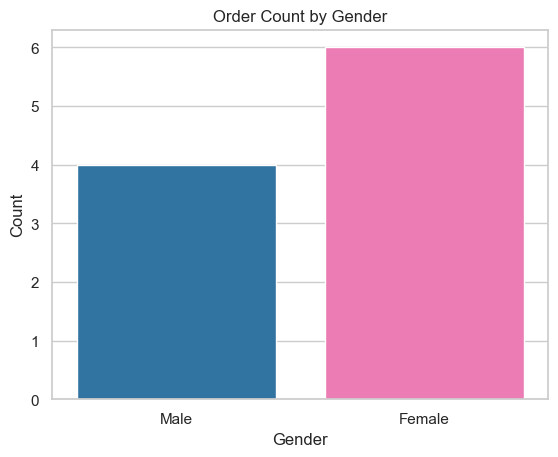

In [47]:
# Fix any inconsistent gender values
df_orders['Gender'] = df_orders['Gender'].str.strip().str.title()

# Gender-wise colors
palette = {
    "Male": "#1f77b4",     # Blue
    "Female": "#ff69b4"    # Pink
}

# Correct countplot
sns.countplot(x='Gender', hue='Gender', data=df_orders, palette=palette)

# Formatting
plt.title("Order Count by Gender")
plt.ylabel("Count")
plt.xlabel("Gender")
plt.show()

### 2.Total Sales by Product Categor

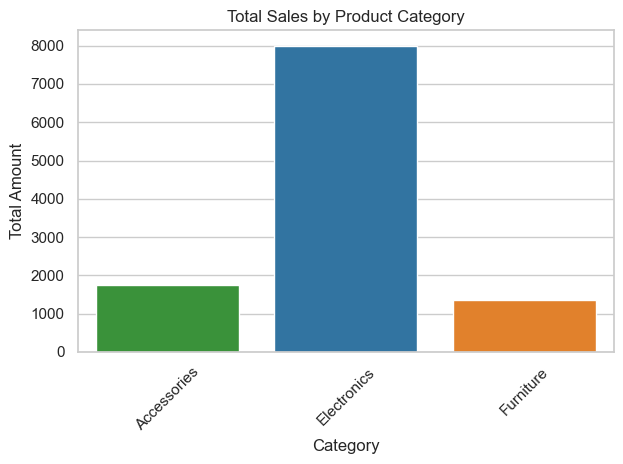

In [48]:
# Group data
category_sales = df_orders.groupby("Category")["TotalAmount"].sum().reset_index()

# Define category-specific colors
palette = {
    "Electronics": "#1f77b4",
    "Accessories": "#2ca02c",
    "Furniture": "#ff7f0e"
}

# Use hue and suppress legend
sns.barplot(x="Category", y="TotalAmount", hue="Category", data=category_sales, palette=palette, legend=False)

# Plot formatting
plt.title("Total Sales by Product Category")
plt.ylabel("Total Amount")
plt.xlabel("Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.Sales by Country

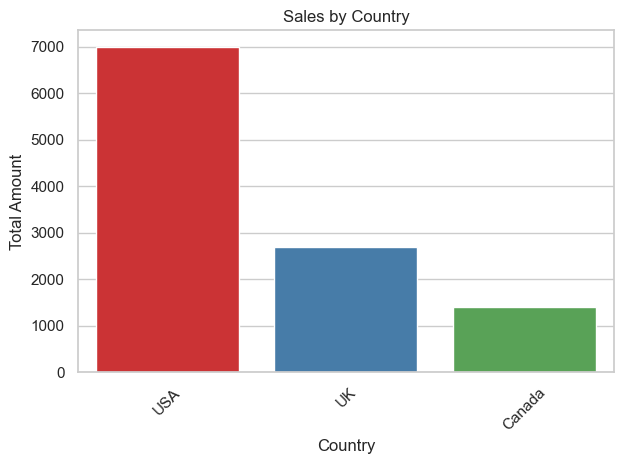

In [49]:
# Group and sort data
country_sales = df_orders.groupby("Country")["TotalAmount"].sum().reset_index()
country_sales = country_sales.sort_values("TotalAmount", ascending=False)

# Create color palette from bright palette
countries = country_sales["Country"].tolist()
palette = dict(zip(countries, sns.color_palette("bright", n_colors=len(countries))))


# Plot
sns.barplot(
    x="Country",
    y="TotalAmount",
    hue="Country",
    data=country_sales,
    palette="Set1",
    legend=False
)

# Formatting
plt.title("Sales by Country")
plt.ylabel("Total Amount")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [50]:
orders = pd.read_sql("SELECT * FROM orders", conn)
customers = pd.read_sql("SELECT * FROM customers", conn)
products = pd.read_sql("SELECT * FROM products", conn)


In [51]:
# Merge orders with customers to get country
merged_df = orders.merge(customers, on="CustomerID").merge(products, on="ProductID")

# Group by country and calculate average price of products ordered
country_product_price = merged_df.groupby("Country")["Price"].mean().reset_index()

# Rename column for clarity
country_product_price.rename(columns={"Price": "avg_product_price"}, inplace=True)

# Sort by price descending
country_product_price = country_product_price.sort_values("avg_product_price", ascending=False)


In [52]:
# View result
print(country_product_price)

  Country  avg_product_price
2     USA        1000.000000
1      UK         462.500000
0  Canada         216.666667


### 4.Average Product Price by Country

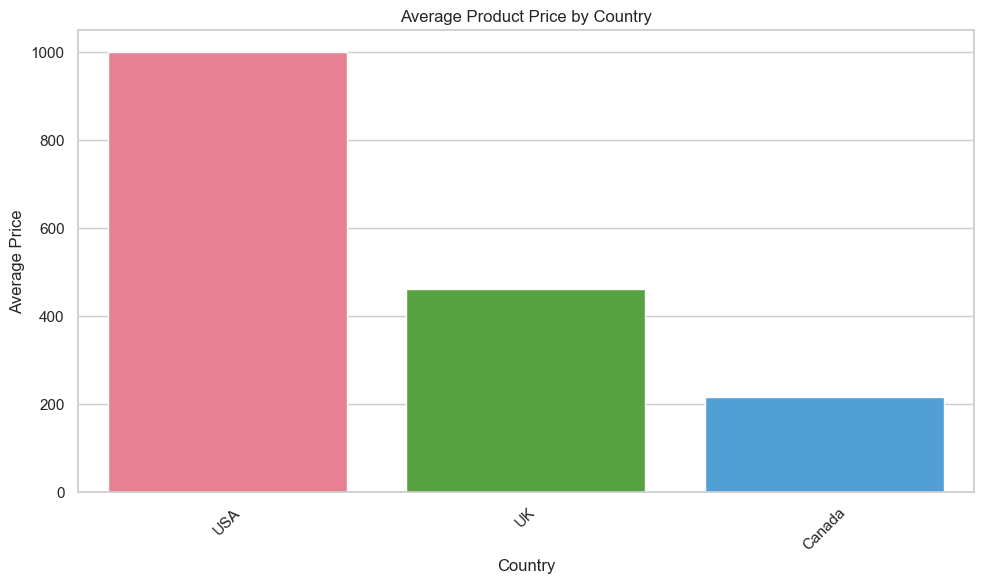

In [53]:
plt.figure(figsize=(10, 6))

sns.barplot(
    x="Country", 
    y="avg_product_price", 
    hue="Country",              # Tell seaborn to color by country
    data=country_product_price,
    palette="husl",             # Assign unique color per country
    dodge=False,                # Keeps bars from being grouped
    legend=False                # Hides redundant legend
)

plt.title("Average Product Price by Country")
plt.xlabel("Country")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 5. Top 3 Products by Sales

In [54]:
df_orders["TotalSales"] = df_orders["Quantity"] * df_orders["Price"]
top_products = df_orders.groupby("ProductName")["TotalSales"].sum().reset_index()
top_products = top_products.sort_values(by="TotalSales", ascending=False).head(3)

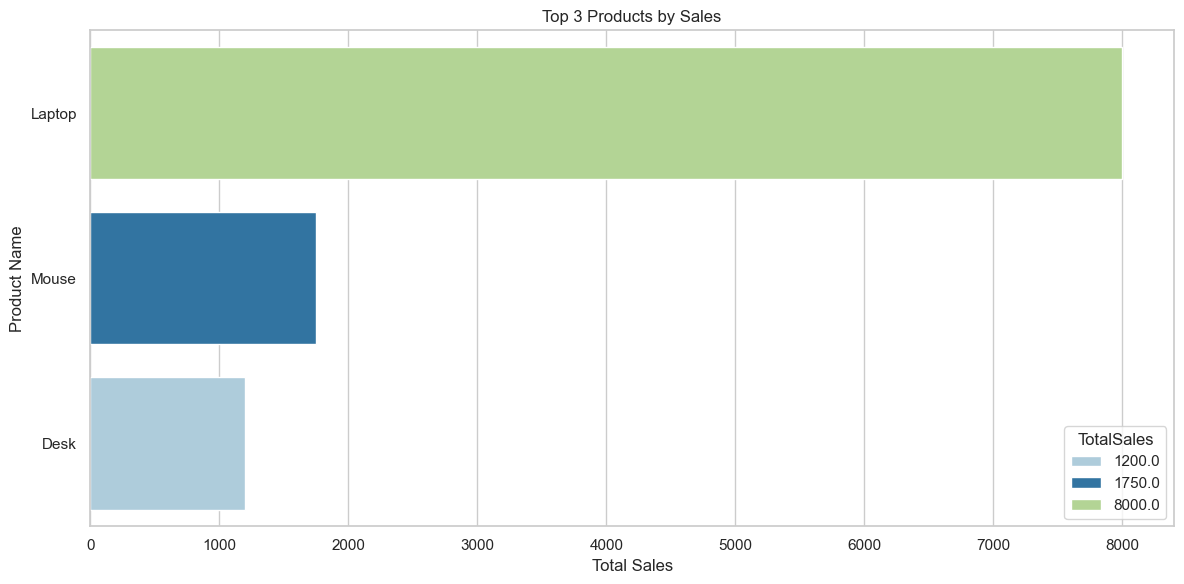

In [55]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top_products, x="TotalSales", y="ProductName",hue="TotalSales", palette="Paired")
plt.title("Top 3 Products by Sales")
plt.xlabel("Total Sales")
plt.ylabel("Product Name")
plt.tight_layout()
plt.show()

### 6.Monthly Sales Trend

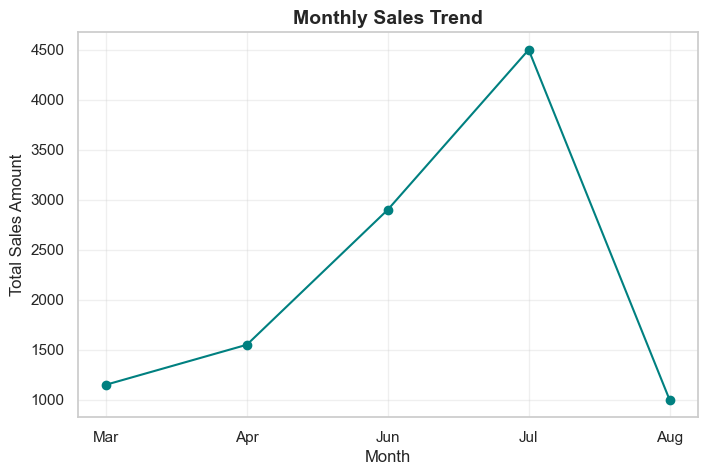

In [56]:
# Convert OrderDate to datetime and extract month
df_orders["OrderDate"] = pd.to_datetime(df_orders["OrderDate"])
df_orders["Month"] = df_orders["OrderDate"].dt.strftime("%b")  # Month abbreviation

# Group by Month and sum TotalAmount
monthly_sales = df_orders.groupby("Month")["TotalAmount"].sum().reindex(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
).dropna()

# Plot monthly sales
plt.figure(figsize=(8,5))
plt.plot(monthly_sales.index, monthly_sales.values, marker="o", linestyle="-", color="teal")
plt.title("Monthly Sales Trend", fontsize=14, fontweight="bold")
plt.xlabel("Month")
plt.ylabel("Total Sales Amount")
plt.grid(True, alpha=0.3)
plt.show()

## Excel-like Queries in Jupyter (with Pandas)

### 1. Total Sales (like =SUM(TotalAmount))

In [57]:
total_sales = df_orders['TotalAmount'].sum()
print("Total Sales:", total_sales)

Total Sales: 11100.0


### 2. Total Sales by Country (like =SUMIF)

In [58]:
sales_by_country = df_orders.groupby('Country')['TotalAmount'].sum().reset_index()
sales_by_country

,Country,TotalAmount
0,Canada,1400.0
1,UK,2700.0
2,USA,7000.0


### 3. Top 4 Products by Sales (like =SUMIFS + =SORT)

In [59]:
top_products = df_orders.groupby('ProductName')['TotalAmount'].sum().sort_values(ascending=False).head(5).reset_index()
top_products

,ProductName,TotalAmount
0,Laptop,8000.0
1,Mouse,1750.0
2,Desk,1200.0
3,Chair,150.0


### 4. Number of Orders by Gender (like =COUNTIF)

In [60]:
orders_by_gender = df_orders['Gender'].value_counts().reset_index()
orders_by_gender.columns = ['Gender', 'OrderCount']
orders_by_gender

,Gender,OrderCount
0,Female,6
1,Male,4


### 5. Average Order Value (like =AVERAGE)

In [61]:
average_order_value = df_orders['TotalAmount'].mean()
print("Average Order Value:", average_order_value)

Average Order Value: 1110.0


### 6.Monthly Sales Trend (like =MONTH() + =SUMIFS)

In [62]:
df_orders['Month'] = pd.to_datetime(df_orders['OrderDate']).dt.to_period('M')
monthly_sales = df_orders.groupby('Month')['TotalAmount'].sum().reset_index()
monthly_sales

,Month,TotalAmount
0,2025-03,1150.0
1,2025-04,1550.0
2,2025-06,2900.0
3,2025-07,4500.0
4,2025-08,1000.0


### 7. Sales by Category (like =PIVOT TABLE)

In [63]:
sales_by_category = df_orders.groupby('Category')['TotalAmount'].sum().reset_index()
sales_by_category

,Category,TotalAmount
0,Accessories,1750.0
1,Electronics,8000.0
2,Furniture,1350.0


### 8. Top Customers (like =SUMIFS by Customer)

In [64]:
top_customers = df_orders.groupby('Customer')['TotalAmount'].sum().sort_values(ascending=False).head(5).reset_index()
top_customers

,Customer,TotalAmount
0,Rani,4000.0
1,Mahesh,2000.0
2,Alice,1900.0
3,Bob,1900.0
4,Clara,500.0


### 9. Filtering Orders from UK (like =FILTER)


In [65]:
orders_usa = df_orders[df_orders['Country'] == 'UK']
orders_usa.head()

,OrderID,Customer,Gender,Country,ProductName,Category,Price,Quantity,OrderDate,TotalAmount,TotalSales,Month
0,1,Bob,Male,UK,Laptop,Electronics,1000.0,1,2025-03-01,1000.0,1000.0,2025-03
4,5,David,Male,UK,Desk,Furniture,300.0,1,2025-04-10,300.0,300.0,2025-04
6,7,Bob,Male,UK,Desk,Furniture,300.0,3,2025-06-08,900.0,900.0,2025-06
9,10,sunitha,Female,UK,Mouse,Accessories,250.0,2,2025-07-03,500.0,500.0,2025-07


### 10. Find Product with Highest Revenue (like =MAX)

In [66]:
max_product = df_orders.groupby('ProductName')['TotalAmount'].sum().idxmax()
print("Highest Revenue Product:", max_product)

Highest Revenue Product: Laptop
